### CartPole-DQN

In [1]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from tensorflow.losses import huber_loss

Using TensorFlow backend.
C:\Users\Moon\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Moon\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Moon\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Moon\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
# hparams

NUM_EPISODES = 500
MAX_STEPS = 200
GAMMA = 0.99
WARMUP = 10

E_START = 1.0
E_STOP = 0.01
E_DECAY_RATE = 0.001

MEMORY_SIZE = 10000
BATCH_SIZE = 32

In [3]:
class QNetwork:
    def __init__(self, state_size, action_size):
        # create model
        self.model = Sequential()
        self.model.add(Dense(16, activation='relu', input_dim=state_size))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        
        self.model.compile(loss=huber_loss, optimizer=Adam(lr=0.001))

In [4]:
# experience memory

class Memory():
    def __init__(self, memory_size):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# create environment

env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [6]:
main_qn = QNetwork(state_size, action_size)
target_qn = QNetwork(state_size, action_size)
memory = Memory(MEMORY_SIZE)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# learning

state = env.reset()
state = np.reshape(state, [1, state_size])

total_step = 0
success_count = 0

for episode in range(1, NUM_EPISODES+1):
    step = 0
    
    # set weights of target Q-Network
    target_qn.model.set_weights(main_qn.model.get_weights())
    
    for _ in range(1, MAX_STEPS+1):
        step += 1
        total_step += 1
        
        # epsilon decay
        epsilon = E_STOP + (E_START - E_STOP) * np.exp(-E_DECAY_RATE * total_step)
        
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(main_qn.model.predict(state)[0])
            
        next_state, _, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        if done:
            if step >= 190:
                success_count += 1
                reward = 1
            else:
                success_count = 0
                reward = 0
                
            # empty state
            next_state = np.zeros(state.shape)
            
            if step > WARMUP:
                memory.add((state, action, reward, next_state))
        else:
            reward = 0
            
            if step > WARMUP:
                memory.add((state, action, reward, next_state))
                
            state = next_state
            
        if len(memory) >= BATCH_SIZE:
            inputs = np.zeros((BATCH_SIZE, 4)) # input (state)
            targets = np.zeros((BATCH_SIZE, 2)) # output (value of each action)
            
            minibatch = memory.sample(BATCH_SIZE)
            
            for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
                inputs[i] = state_b
                
                # compute value
                if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                    target = reward_b + GAMMA * np.amax(target_qn.model.predict(next_state_b)[0])
                else:
                    target = reward_b
                    
                targets[i] = main_qn.model.predict(state_b)
                targets[i][action_b] = target
                
            main_qn.model.fit(inputs, targets, nb_epoch=1, verbose=0)
            
        if done:
            break
            
    print('에피소드: {}, 스텝 수: {}, epsilon: {:.4f}'.format(episode, step, epsilon))
    
    # stop learning when successes 5 times in a row
    if success_count >= 5:
        break
        
    state = env.reset()
    state = np.reshape(state, [1, state_size])

에피소드: 1, 스텝 수: 38, epsilon: 0.9631
에피소드: 2, 스텝 수: 31, epsilon: 0.9340
에피소드: 3, 스텝 수: 12, epsilon: 0.9230
에피소드: 4, 스텝 수: 23, epsilon: 0.9022
에피소드: 5, 스텝 수: 74, epsilon: 0.8386
에피소드: 6, 스텝 수: 27, epsilon: 0.8165
에피소드: 7, 스텝 수: 15, epsilon: 0.8045
에피소드: 8, 스텝 수: 47, epsilon: 0.7680
에피소드: 9, 스텝 수: 135, epsilon: 0.6723
에피소드: 10, 스텝 수: 24, epsilon: 0.6566
에피소드: 11, 스텝 수: 66, epsilon: 0.6153
에피소드: 12, 스텝 수: 14, epsilon: 0.6069
에피소드: 13, 스텝 수: 39, epsilon: 0.5840
에피소드: 14, 스텝 수: 55, epsilon: 0.5533
에피소드: 15, 스텝 수: 78, epsilon: 0.5126
에피소드: 16, 스텝 수: 41, epsilon: 0.4924
에피소드: 17, 스텝 수: 15, epsilon: 0.4852
에피소드: 18, 스텝 수: 36, epsilon: 0.4684
에피소드: 19, 스텝 수: 42, epsilon: 0.4495
에피소드: 20, 스텝 수: 133, epsilon: 0.3948
에피소드: 21, 스텝 수: 127, epsilon: 0.3489
에피소드: 22, 스텝 수: 91, epsilon: 0.3194
에피소드: 23, 스텝 수: 52, epsilon: 0.3037
에피소드: 24, 스텝 수: 65, epsilon: 0.2853
에피소드: 25, 스텝 수: 106, epsilon: 0.2576
에피소드: 26, 스텝 수: 146, epsilon: 0.2239
에피소드: 27, 스텝 수: 67, epsilon: 0.2101
에피소드: 28, 스텝 수: 74, epsilon: 0.1

In [ ]:
# display settings (for Google Colab)

from pyvirtualdisplay import Display
import os
disp = Display(visible=0, size=(1024, 768))
disp.start()
os.environ['DISPLAY'] = ':' + str(disp.display) + '.' + str(disp.screen)

In [39]:
frames = []

tate = env.reset()
state = np.reshape(state, [1, state_size])

step = 0

for _ in range(1, MAX_STEPS+1):
    step += 1
    
    frames.append(env.render(mode='rgb_array'))
    
    action = np.argmax(main_qn.model.predict(state)[0])
    
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    
    if done:
        next_state = np.zeros(state.shape)
        break
    else:
        state = next_state
        
print('스텝 수: {}'.format(step))

스텝 수: 200


MovieWriter ffmpeg unavailable; using Pillow instead.


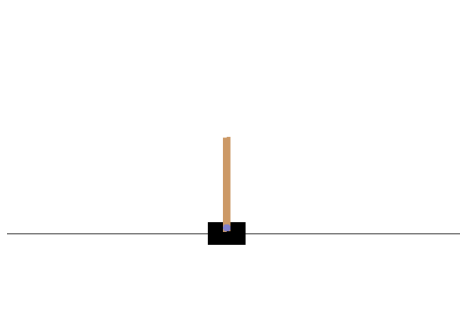

In [43]:
# animation settings

import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
from IPython.display import HTML

def display_frames_as_gif(frames):
    plt.figure(figsize = (frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save('movie_cartpole.gif')
    # display(display_animation(anim, default_mode='loop'))
    display(HTML(anim.to_jshtml()))

display_frames_as_gif(frames)